In [1]:
import time
import sys
import os
path_project = "\\".join(os.getcwd().split("\\")[:-1])
# caution: path[0] is reserved for script path (or '' in REPL)
sys.path.insert(1, path_project)

from hardware.pulser.pulser import PulseGenerator, OutputState, TriggerStart, TriggerRearm, HIGH, LOW, INF
from hardware.laser.laser import LaserControl
from hardware.mw.mwsynthesizer import Synthesizer

from hardware import config as hcf

import nidaqmx
from nidaqmx.constants import TerminalConfiguration, VoltageUnits, Edge, AcquisitionType, READ_ALL_AVAILABLE
# from nidaqmx.constants import LogicFamily 
# TWO_POINT_FIVE_V, THREE_POINT_THREE_V, FIVE_V
# from nidaqmx import stream_readers 
# from nidaqmx.stream_readers import AnalogSingleChannelReader

import numpy as np
import numpy as np
from windfreak import SynthHD
from math import floor
import time
import matplotlib.pyplot as plt

import plotly.graph_objects as go
import plotly.express as px

In [2]:
# connect to the windfreak mw driver 
synth = SynthHD('COM4')
synth.init()

In [3]:
# connect to devices
pg  = PulseGenerator(ip=hcf.PS_IP, chmap=hcf.PS_chmap) 
# mwsyn = Synthesizer(hcf.VDISYN_SN, 
#                     vidpid=hcf.VDISYN_VIDPID,
#                     baudrate=hcf.VDISYN_BAUD, 
#                     timeout=5, 
#                     write_timeout=5)
# mwsyn.reboot()
laser = LaserControl(hcf.LASER_SN)
laser.open()


Connect to Pulse Streamer via JSON-RPC.
IP / Hostname: 192.168.1.26
Pulse Streamer 8/2 firmware: v1.7.2
Client software: v1.7.0


In [4]:
current_percent = 75.09
laser.laser_off()
laser.set_analog_control_mode("current")
laser.set_modulation_state("Pulsed")
laser.set_diode_current(current_percent, save_memory=False)

In [5]:
from hardware.daq.sidig import FIFO_DataAcquisition
from hardware.daq.sidig import FIFO_DataAcquisition, DCCOUPLE, TERMIN_INPUT_50OHM, TERMIN_INPUT_1MOHM

SIDIG_ADDRESS = "dev/spcm0"
SIDIG_maxsr = 500e6  # Hz
SIDIG_timebase = int(1 / SIDIG_maxsr * 1e9)  # ns
dig=FIFO_DataAcquisition(
                sn_address=SIDIG_ADDRESS
            )

In [6]:
ch = synth[0]  
ch.power = -60
ch.frequency = 400*1e6
ch.enable = False
synth.enable=False

In [7]:
# # set MW power =====================================================
# mwpower_vlevel = 5.0 # 5V equals to max power
# task_uca = nidaqmx.Task("UCA") # user controlled attenuation
# task_uca.ao_channels.add_ao_voltage_chan(hcf.NI_ch_UCA, min_val=0.0, max_val=10)
# # task_uca.timing.cfg_samp_clk_timing(hcf.NI_sampling_max/100.0, sample_mode=AcquisitionType.CONTINUOUS)
# task_uca.start()
# task_uca.write([mwpower_vlevel], auto_start=False)
# # task_uca.stop()
# # task_uca.close()

In [8]:
dur_pt = 16E6 # duration of each frequency point
dig_trig_len=20
divpart_pt = 2
clock_rate = 500E-6 #GHz
daqtrig_delay = 1/clock_rate #delay
seq_daqtrig = [(dur_pt/2.0, HIGH), (dur_pt/2.0, LOW)]
seq_laser = [(dur_pt, HIGH)]
seq_mwA = [(dur_pt/2.0/divpart_pt, HIGH), (dur_pt/2.0/divpart_pt, LOW)]*divpart_pt
seq_clock = [(0.5/clock_rate, HIGH),(0.5/clock_rate, LOW)]*int(dur_pt*clock_rate)
# seq_dig= [(dur_pt/2.0/divpart_pt, LOW), (dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW),(dig_trig_len,HIGH),(dur_pt/2.0/divpart_pt/2-2*dig_trig_len, LOW)]*divpart_pt
seq_dig= [(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW),(dig_trig_len,LOW),(dig_trig_len,HIGH), (dur_pt/2.0/divpart_pt-dig_trig_len, LOW)]*divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital('sdtrig',seq_dig)
# pg.setDigital("laser", seq_mwA)
# pg.setDigital("mw_A", seq_laser)
# pg.setDigital("dtrig", seq_daqtrig)
# pg.setDigital("dclk", seq_clock)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [9]:
dig_trig_len = 20
divpart_pt = 2

mw_dur = 16e6//4

seq_laser = [(mw_dur, HIGH)]
seq_mwA = [
    (mw_dur, HIGH),
    (mw_dur, LOW),
] * divpart_pt

seq_dig = [
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
    (dig_trig_len, LOW),
    (dig_trig_len, HIGH),
    (mw_dur - dig_trig_len, LOW),
] * divpart_pt

pg.setDigital("laser", seq_laser)
pg.setDigital("mwA", seq_mwA)
pg.setDigital("sdtrig", seq_dig)
pg.setTrigger(start=TriggerStart.SOFTWARE, rearm=TriggerRearm.MANUAL)
pg.plotSeq(plot_all=False)

In [10]:
def seqtime_tb(seq_tb):
    return np.sum([pulse[-1] for pulse in seq_tb])
def seqtime_cb(seq_cb):
    return np.sum([pulse[-0] for pulse in seq_cb])

In [11]:
## set up the data aquication with the digitizer 
# min_volt = -0.002 # [V]
# max_volt = 0.010 # [V]
mw_len=dur_pt/2.0/divpart_pt
t_seq = seqtime_cb(seq_laser)
rate_refresh = 1 # Hz rate of refreshing the data streaming
amp_input = 1000
readout_ch = hcf.SIDIG_chmap["apd"]
num_segment = int(2/rate_refresh*1e9/t_seq)//32*32

# configures the readout to match the pulse sequence  
pretrig_size= 256 #int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # pretrigger based on the t_wait time
# posttrig_size=int((t_ribloc+t_ribloc_isc)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc
posttrig_size=int((mw_len//2)*hcf.SIDIG_maxsr/1E9)//64*64 # posttrigger based on the t_laser time and t_isc

segment_size = pretrig_size+posttrig_size 
segment_size = 2**int(np.log2(segment_size)+1) # make it power of 2
posttrig_size = segment_size-pretrig_size # recalculate posttrigger size to ensure it is power of 2

In [12]:
# To set the configuration, make a dictionary with the key and value
dig.reset_param()
dig.assign_param(dict(
             readout_ch=readout_ch, 
             amp_input=amp_input, 
             num_segment=8,
             pretrig_size=16,
             posttrig_size=1048576//4-16,
             segment_size=1048576//4,
             terminate_input=TERMIN_INPUT_1MOHM,
             DCCOUPLE = 0,
             sampling_rate=hcf.SIDIG_maxsr
            #  terminate_input=TERMIN_INPUT_50OHM,
             ))


In [13]:
pretrig_size=128
posttrig_size=1024*1000-pretrig_size
freq_start = 16.45-0.25
freq_stop = 16.45+0.25
B = 14.103
f_e = 28.0249514242*B
f_NVp1 = f_e + 2.8705
f_NVm1 = f_e - 2.8705
# f_NVguess = 392.8397714495659
f_NVguess = 398.5567714869976
freq_start = ((f_NVguess-0.030)/24.0)*1e9 # MHz
freq_stop = ((f_NVguess+0.030)/24.0)*1e9 # MHz
# check the minium step size
# freqminstep_list = mwsyn.get_min_step_size([freq_start], [freq_stop])
# step_min = freqminstep_list[0] # in Hz

freq_step = .05*1e6 # step size in MHz 
# freq_step = int(freq_step/step_min*1E9)*step_min/1E9

freq_array = np.arange(freq_start, freq_stop, freq_step)

# print(f"Estimated time for one sweep:{(freq_stop-freq_start)/freq_step*max(10E6, dur_pt)/1E9} s")
# 
# Allocate arrays
signal = np.zeros((len(freq_array), pretrig_size + posttrig_size))
background = np.zeros((len(freq_array), pretrig_size + posttrig_size))

# Repeat measurement
num_repeat = 1
signal_av = np.zeros(len(freq_array))
background_av = np.zeros(len(freq_array))
segment_list = np.zeros(len(freq_array))


In [14]:
freq_array

array([1.66052821e+10, 1.66053321e+10, 1.66053821e+10, 1.66054321e+10,
       1.66054821e+10, 1.66055321e+10, 1.66055821e+10, 1.66056321e+10,
       1.66056821e+10, 1.66057321e+10, 1.66057821e+10, 1.66058321e+10,
       1.66058821e+10, 1.66059321e+10, 1.66059821e+10, 1.66060321e+10,
       1.66060821e+10, 1.66061321e+10, 1.66061821e+10, 1.66062321e+10,
       1.66062821e+10, 1.66063321e+10, 1.66063821e+10, 1.66064321e+10,
       1.66064821e+10, 1.66065321e+10, 1.66065821e+10, 1.66066321e+10,
       1.66066821e+10, 1.66067321e+10, 1.66067821e+10, 1.66068321e+10,
       1.66068821e+10, 1.66069321e+10, 1.66069821e+10, 1.66070321e+10,
       1.66070821e+10, 1.66071321e+10, 1.66071821e+10, 1.66072321e+10,
       1.66072821e+10, 1.66073321e+10, 1.66073821e+10, 1.66074321e+10,
       1.66074821e+10, 1.66075321e+10, 1.66075821e+10, 1.66076321e+10,
       1.66076821e+10, 1.66077321e+10])

In [15]:
import time

def wait_until(condition_func, timeout=None, check_interval=0.1):
    """
    Wait until condition_func() returns True, or timeout is reached.
    
    Parameters:
        condition_func (callable): A no-argument function that returns True when the condition is met.
        timeout (float or None): Max time (in seconds) to wait, or None for infinite.
        check_interval (float): Time (in seconds) to sleep between checks.
    """
    start_time = time.monotonic()
    while not condition_func():
        if timeout is not None and time.monotonic() - start_time > timeout:
            raise TimeoutError("wait_until timeout expired.")
        time.sleep(check_interval)

In [16]:

laser.laser_on() # turn off laser

for mmm in range(num_repeat):
    for jj, ff in enumerate(freq_array):
        # print(f"Frequency: {ff} GHz")
        run_time = .1
        segments = 0
        
        dig.assign_param(dict(
            readout_ch=readout_ch,
            amp_input=amp_input,
            num_segment=8,
            pretrig_size=pretrig_size,
            posttrig_size=posttrig_size,
            segment_size=pretrig_size+posttrig_size,
            terminate_input=TERMIN_INPUT_1MOHM,
            DCCOUPLE=0,
            sampling_rate=hcf.SIDIG_maxsr 
        ))
        dig.set_config()
        # errorbyte, freq_array[jj] = mwsyn.cw_frequency(ff)
        # Set channel 0 power and frequency
        synth[0].power = 10
        synth[0].frequency = freq_array[jj]
        synth[0].phase=0
        # Enable channel 0
        synth[0].enable = True
        synth.enable=True
        actually_freq = synth[0].frequency
        # print(f"Set frequency: {actually_freq} Hz")
        # wait_until(lambda: synth[0].frequency == freq_array[jj], timeout=10)
        pg.stream(n_runs=INF)  # Example function for pulse generator (replace with actual implementation)
        dig.start_buffer()
        pg.startNow()

        start_time = time.monotonic()
        while time.monotonic() - start_time < run_time:
            rawraw = dig.stream()
            assert rawraw.shape[0] % 2 == 0
            assert rawraw.shape[0] != 0

            rawraw_on = rawraw[0::2, :, :]
            rawraw_off = rawraw[1::2, :, :]
            segments += np.shape(rawraw)[0] // 2
            # print("hello")
            # signal[jj, :] += rawraw_on.reshape(-1, rawraw_on.shape[-1]).sum(axis=0)
            # background[jj, :] += rawraw_off.reshape(-1, rawraw_off.shape[-1]).sum(axis=0)
            # print(f"rawraw_on.shape[0]: {rawraw_on.shape[0]}")
            for ii in range(0,rawraw.shape[0] // 2):
                # print(f"Processing segment {ii} for freq index {jj}")
                signal[jj,:] += np.ravel(rawraw_on[ii])
    
                background[jj,:] += np.ravel(rawraw_off[ii])

        synth[0].enable = False
        synth.enable=False
        dig.stop_card()
        pg.forceFinal()
        # pg.reset()
        segment_list[jj] += segments


Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped
Card stopped


In [17]:
import matplotlib.pyplot as plt

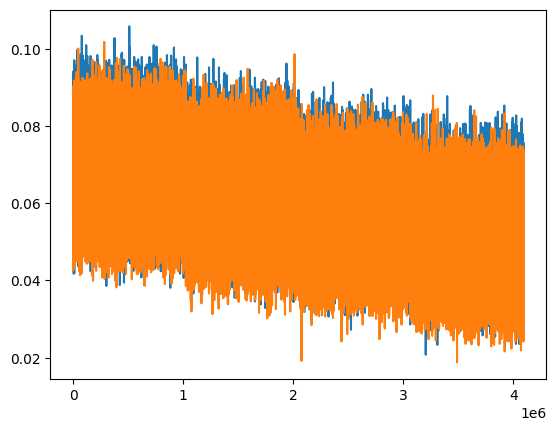

In [18]:
plt.plot(np.ravel(rawraw_on))
plt.plot(np.ravel(rawraw_off))

In [19]:
synth[0].enable = False
synth.enable=False

In [20]:
# turn off laser and set diode current to zero
laser.laser_off() 
laser.set_diode_current(0, save_memory=False)
laser.close()
# reset pulse generator
pg.forceFinal()
pg.constant(OutputState.ZERO())
pg.reset()
pg.reboot()
synth[0].enable = False
synth.enable=False
# # close all NI tasks

# task_uca.stop()
# task_uca.close()

# # reboot(optional) and close the MW synthesizer 
# mwsyn.reboot()
# mwsyn.close()

In [21]:
def avg(data):
    return np.mean(data,axis=1)

In [22]:
on=avg(signal)/segment_list
off=avg(background)/segment_list

In [23]:
import matplotlib.pyplot as plt

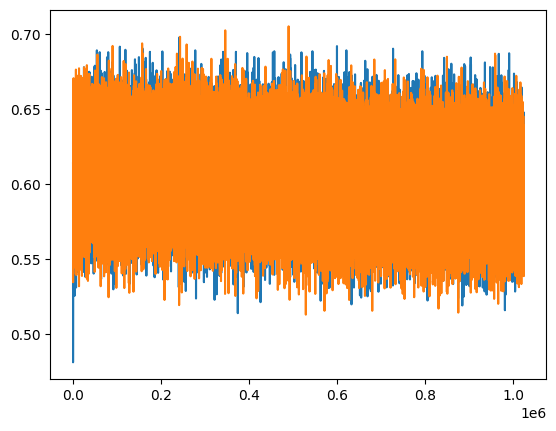

In [24]:
plt.plot(signal[7])
plt.plot(background[7])

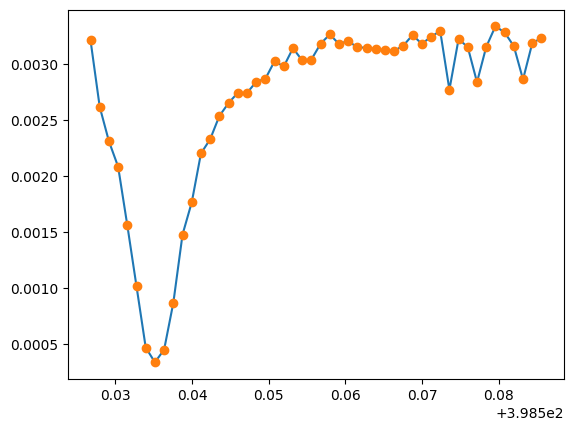

In [25]:
plt.plot((freq_array*24)/1e9, (on-off))
plt.plot((freq_array*24)/1e9, (on-off),marker='o',linestyle='None')


In [26]:
min_index = np.argmin((on-off)/off)
print(min_index)  # Output: 3
freq_array[15]*24/(1e9)

7


398.54477148699766

In [27]:
freq_array[15]/(1e6)

16606.03214529157